In [1]:
# Import necessary libraries
import scanpy as sc
import pandas as pd
import anndata as ad
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact, ranksums, spearmanr
from itertools import combinations
from statsmodels.stats.multitest import multipletests

from datetime import datetime

# Get current date formatted as yymmdd
formatted_date = datetime.now().strftime('%y%m%d')
clustering_resolution = 0.5

#os.chdir('/home/ak431480')

### Function definitions

In [2]:
def compute_cell_type_percentages(dat, col_name):
    obs_df = dat.obs.copy()
    obs_df['count'] = 1  # Add a count term

    # Total cell count per sample
    total_cell_count = obs_df[['sample', 'count']].groupby('sample', observed=False).sum()

    # Initialize percentage dataframe
    pct_df = pd.DataFrame(index=total_cell_count.index)

    # Calculate percentages for each category in the specified column
    for cat in obs_df[col_name].cat.categories:
        df = obs_df[obs_df[col_name] == cat].copy()
        df = df[['sample', 'count']].groupby('sample', observed=False).sum()
        df = df.loc[pct_df.index]
        pct_df[cat] = (df['count'] / total_cell_count['count'])

    # Convert to percentage
    pct_df *= 100

    # Check if percentages sum to 100
    if (pct_df.sum(axis=1).round(4) == 100).all():
        print('Successfully created percentage dataframe')

    # Filter columns based on value counts
    val_counts = dat.obs[col_name].value_counts()
    pct_df = pct_df[val_counts.index]

    # Add total counts as a new row
    pct_df.loc['total_n'] = val_counts

    # Map sample types
    sample_type_map = obs_df[['sample', 'type']].groupby('sample', observed=False).first().to_dict()['type']
    pct_df['type'] = pct_df.index.map(sample_type_map)
    pct_df['type'] = pd.Categorical(pct_df['type'], categories=obs_df['type'].cat.categories)

    return pct_df

# Function to determine significance level
def significance_marker(pval):
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return None


def print_pvalues(df, value_col='value', group_col='type', variable_col='variable'):
    # Reshape the dataframe for comparison
    plot_df = df.set_index(group_col).melt(ignore_index=False).reset_index(drop=False)

    # Iterate over each variable and compute p-values
    for ctype in plot_df[variable_col].unique():
        txt = ctype
        df_sub = plot_df[plot_df[variable_col] == ctype]

        # Ensure 'type' is categorical for consistent ordering
        if not pd.api.types.is_categorical_dtype(df_sub[group_col]):
            df_sub[group_col] = pd.Categorical(df_sub[group_col])

        for g1, g2 in combinations(df_sub[group_col].cat.categories, 2):
            stat, pval = ranksums(df_sub[df_sub[group_col] == g1][value_col],
                                  df_sub[df_sub[group_col] == g2][value_col])
            marker = significance_marker(pval)
            if marker:
                txt += f'\n{g1} vs {g2}: p = {pval:.4f} {marker}'
            else:
                txt += f'\n{g1} vs {g2}: p = {pval:.4f}'
        print(txt)
        print('')



## Load data

In [3]:
# Load scs data
base_dir = '/scratch/svc_td_compbio/users/kiviaho'
adata_concat = sc.read_h5ad(f'{base_dir}/preprocessed_h5ad/lyu_2024_cell_subtypes_for_cell2location_mapping_251014.h5ad')

# Celltype_annotation
celltype_annotation_df = pd.read_excel('/home/ak431480/single_cell_celltype_annotation.xlsx',index_col=0)
celltype_annot_dict = celltype_annotation_df.to_dict()['celltype name']

# Map the annotation
adata_concat.obs['annotated celltypes'] = adata_concat.obs['celltype_leiden'].map(celltype_annot_dict)
adata_concat = adata_concat[~(adata_concat.obs['annotated celltypes'] == 'drop')].copy()

In [79]:
obs_data = adata_concat.obs.copy()
obs_data = obs_data[obs_data['type'] == 'HSPC']
# Lose irrelevant celltypes
celltype_annotation_df = celltype_annotation_df[celltype_annotation_df['celltype name'].isin(obs_data['annotated celltypes'])]


counts = (
    obs_data
    .groupby(['sample', 'annotated celltypes'])
    .size()
    .rename('n')
    .reset_index()
)
counts = counts.pivot(
    index = 'sample',
    columns = 'annotated celltypes',
    values = 'n'
)

# Drop samples with less than 100 profiled cells
counts = counts[counts.sum(axis=1) >= 100]

unique_celltypes = celltype_annotation_df['broad celltype'].unique().tolist()
counts_norm = pd.DataFrame(index = counts.index, columns = counts.columns)
celltype_numbers = pd.DataFrame(index = counts.index, columns = unique_celltypes)

for broad_ctype in unique_celltypes:
    ctype_categories = celltype_annotation_df[celltype_annotation_df['broad celltype'] == broad_ctype]['celltype name'].tolist()
    rowsums = counts[ctype_categories].sum(axis=1)

    celltype_numbers[broad_ctype] = rowsums
    # If less than 100 total cells, annotate nan
    rowsums[rowsums < 100] = np.nan
    counts_norm[ctype_categories] = counts[ctype_categories].div(rowsums,axis=0) * 100

celltype_numbers_norm = celltype_numbers.div(celltype_numbers.sum(axis=1),axis=0) * 100

# With the number of broad celltypes added
counts_norm = pd.concat([counts_norm,celltype_numbers_norm],axis=1)

/tmp/ipykernel_209799/3624270857.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['sample', 'annotated celltypes'])


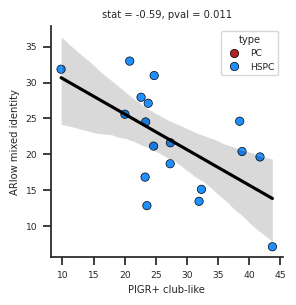

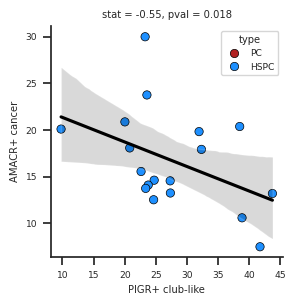

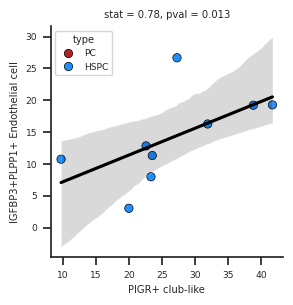

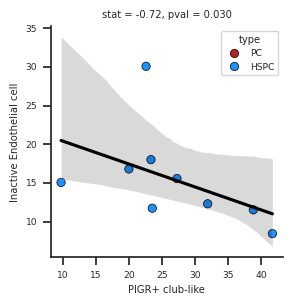

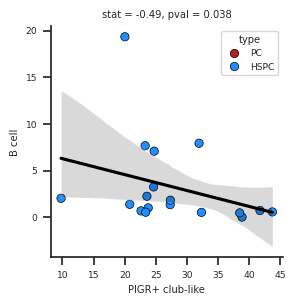

In [80]:

sns.set_theme(
    style='white',
    palette=sns.color_palette(['firebrick','dodgerblue']),
    font_scale=0.6,
    rc={'xtick.bottom': True, 'ytick.left': True}
)

plot_df = counts_norm.copy()

# Add the type annotation to this df
plot_df['type'] = pd.Categorical(plot_df.index.map(obs_data[['sample','type']].set_index('sample').to_dict()['type']),categories=['PC','HSPC'])

ctype1 = 'PIGR+ club-like'

for ctype2 in counts_norm.mean(axis=0).sort_values(ascending=False).index.tolist():

    if ctype1 != ctype2:

        df = counts_norm[[ctype1,ctype2]].dropna()
        stat,pval = spearmanr(df[ctype1],df[ctype2])
        
        if pval < 0.05:
            fig, ax = plt.subplots(figsize=(3,3))
            sns.scatterplot(
                plot_df,
                x = ctype1,
                y = ctype2,
                linewidth = 0.5,
                edgecolor='k',
                hue='type'
            )
            sns.regplot(
                plot_df,
                x = ctype1,
                y = ctype2,
                scatter = False,
                color = 'black'
                )


            plt.title(f'stat = {stat:.2f}, pval = {pval:.3f}')

            ax.spines[['top','right']].set_visible(False)
            plt.show()

In [67]:
counts['CD4+FOXP3+ T cell']

sample
HSPC_S08      0
HSPC_S09      0
HSPC_S10     65
HSPC_S11    514
HSPC_S12      2
HSPC_S14      1
HSPC_S15     15
HSPC_S16     33
HSPC_S17      2
HSPC_S18      0
HSPC_S19      0
HSPC_S20      3
HSPC_S21      6
HSPC_S22    102
HSPC_S24      2
HSPC_S25      1
HSPC_S26      0
HSPC_S28      4
HSPC_S29      4
HSPC_S30     13
HSPC_S31      2
Name: CD4+FOXP3+ T cell, dtype: int64

In [7]:
counts_norm.mean(axis=0).sort_values(ascending=False)

annotated celltypes
MS4A2+TPSAB1+ Mast cell           55.340050
CD8A+IFNG+ T cell                 50.708478
ACTA2+RGS5+ Fibroblast            45.252132
AMACR+ cancer                     41.650467
CD74+CD83+ Dendritic cell         37.777376
DCN+LUM+ Fibroblast               37.577593
IL33+PRCP+ Endothelial cell       35.999402
Inactive Mast cell                35.548288
IL1B+TNF+ Macrophage              35.545794
Inactive Macrophage               29.323657
HSPA1A+LTB+ T cell                26.067322
VWF+PLVAP+ Endothelial cell       24.239954
IGFBP3+PLPP1+ Endothelial cell    19.332015
IL32+CST7+ B cell                 16.861138
FCER1A+CD207+ Langerhans          16.587148
Inactive Endothelial cell         15.418567
CD8A+TRGV4+ T cell                15.124686
JCHAIN+IGLC2+ Plasma cell         15.084138
GNLY+CXCL8+ Fibroblast            13.978293
SPP1+MIF+ Macrophage              13.806071
NFKBIA+H2AFZ+ B cell              13.607261
PIGR+ club-like                   12.968644
ARlow mixed 

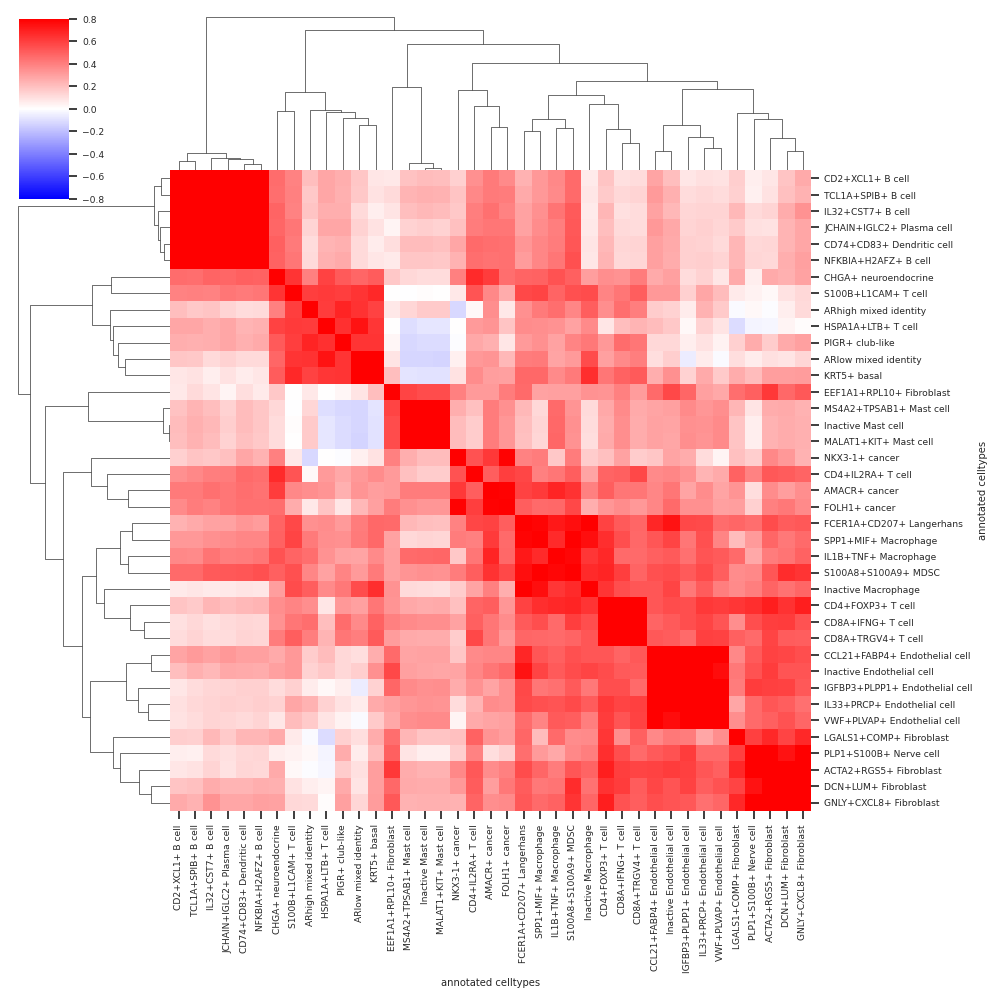

In [222]:

plot_df = counts_norm.fillna(0)
corr = plot_df.corr(method='spearman')

rho, pval = spearmanr(plot_df)

rho = pd.DataFrame(
    rho,
    index=plot_df.columns,
    columns=plot_df.columns
)

pval = pd.DataFrame(
    pval,
    index=plot_df.columns,
    columns=plot_df.columns
)

sns.clustermap(rho,cmap='bwr',vmin=-0.8,vmax=0.8)

## More analysis

In [ ]:
# Load gene modules
gene_modules = pd.read_excel('./prostate_lineage_signatures.xlsx',skiprows=1)
gene_modules_dict = gene_modules.to_dict('list')
for k in gene_modules_dict:
    gene_modules_dict[k] = [g for g in gene_modules_dict[k] if str(g) != 'nan']

# Combine B1_Basal + d1_dLum
gene_modules_dict['B1_Basal-ESR1_d1_dLum-Club'] = gene_modules_dict['B1_Basal-ESR1'] + gene_modules_dict['d1_dLum-Club']
gene_modules_dict['Basal_B1_Basal-ESR1'] = gene_modules_dict['Basal'] + gene_modules_dict['B1_Basal-ESR1']
gene_modules_dict['Ductal_luminal_dLum-Club'] = gene_modules_dict['Ductal luminal'] + gene_modules_dict['d1_dLum-Club']
gene_modules_dict['TISS'] = set(gene_modules_dict['Basal'] + gene_modules_dict['B1_Basal-ESR1'] + gene_modules_dict['Ductal luminal'] + gene_modules_dict['d1_dLum-Club']) # Treatment induced stemness signature

# Combine Hu et al. subtype signatures with the top-level signature
prostate_lineage_signatures_dict = {}
for k in gene_modules_dict:
    print(k)
    sc.tl.score_genes(adata_concat,gene_modules_dict[k],score_name=k,layer='log1p')

Basal
Ductal luminal
Luminal
B1_Basal-ESR1
B2_Basal
B3_Basal-GPRC5A
B4_Basal
B5_Basal-VCAN
B6_Basal-IC1
d1_dLum-Club
d2_dLum-KRT4
d3_dLum-LTF
d4_dLum-NKX3-1
d5_dLum
d6_dLum-CNMD
Lum−LTF
Lum−SFTPA2
Lum−TGM4
Lum−type1
Lum−type2
BPECT Luminal Identity
BPECT Basal Identity
BPECT Club Identity
BPECT Hillock Identity
CRPC-AR
CRPC-WNT
CRPC-NE
CRPC-SCL
JAK_STAT_FGFR
IL1B MDSCs
       'IFNA14', 'IFNA13', 'IFNA17', 'IFNA4', 'CCL3L3', 'IL9'],
      dtype='object')
PMN-MDSCs
B1_Basal-ESR1_d1_dLum-Club
Basal_B1_Basal-ESR1
Ductal_luminal_dLum-Club
TISS


In [ ]:
adata_concat.obs['type'].value_counts()

type
HSPC    60800
PC      59664
CRPC    26716
Name: count, dtype: int64

In [ ]:
# Epithelial
for c in ['Epithelial','T', 'Myeloid']:
    print(f'{c} cell')
    print(adata_concat.obs[adata_concat.obs['cell_type'] == f'{c} cell']['type'].value_counts())
    print('\n')

Epithelial cell
type
HSPC    25872
PC      13273
CRPC     7007
Name: count, dtype: int64


T cell
type
PC      29589
HSPC    18001
CRPC    12546
Name: count, dtype: int64


Myeloid cell
type
PC      7097
HSPC    4585
CRPC    2357
Name: count, dtype: int64




## Epithelial cells

In [7]:
adata = adata_concat[adata_concat.obs['cell_type'] == 'Epithelial cell'].copy()

print('Creating neighborhood graph...')
sc.pp.neighbors(adata, use_rep='X_pca_harmony',random_state=238529)

print('Clustering...')
# Leiden clustering
sc.tl.leiden(adata, resolution=clustering_resolution,key_added='leiden_epi',random_state=665412)

print('Creating UMAP...')
# UMAP visualization
sc.tl.umap(adata)

adata

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating neighborhood graph...
Clustering...


/tmp/ipykernel_1355855/722979009.py:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=clustering_resolution,key_added='leiden_epi',random_state=665412)


Creating UMAP...


AnnData object with n_obs × n_vars = 46152 × 26261
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'Basal', 'Ductal luminal', 'Luminal', 'B1_Basal-ESR1', 'B2_Basal', 'B3_Basal-GPRC5A', 'B4_Basal', 'B5_Basal-VCAN', 'B6_Basal-IC1', 'd1_dLum-Club', 'd2_dLum-KRT4', 'd3_dLum-LTF', 'd4_dLum-NKX3-1', 'd5_dLum', 'd6_dLum-CNMD', 'Lum−LTF', 'Lum−SFTPA2', 'Lum−TGM4', 'Lum−type1', 'Lum−type2', 'BPECT Luminal Identity', 'BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity', 'CRPC-AR', 'CRPC-WNT', 'CRPC-NE', 'CRPC-SCL', 'JAK_STAT_FGFR', 'IL1B MDSCs', 'PMN-MDSCs', 'B1_Basal-ESR1_d1_dLum-Club', 'Basal_B1_Basal-ESR1', 'Ductal_luminal_dLum-Club', 'TISS', 'leiden_epi'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_

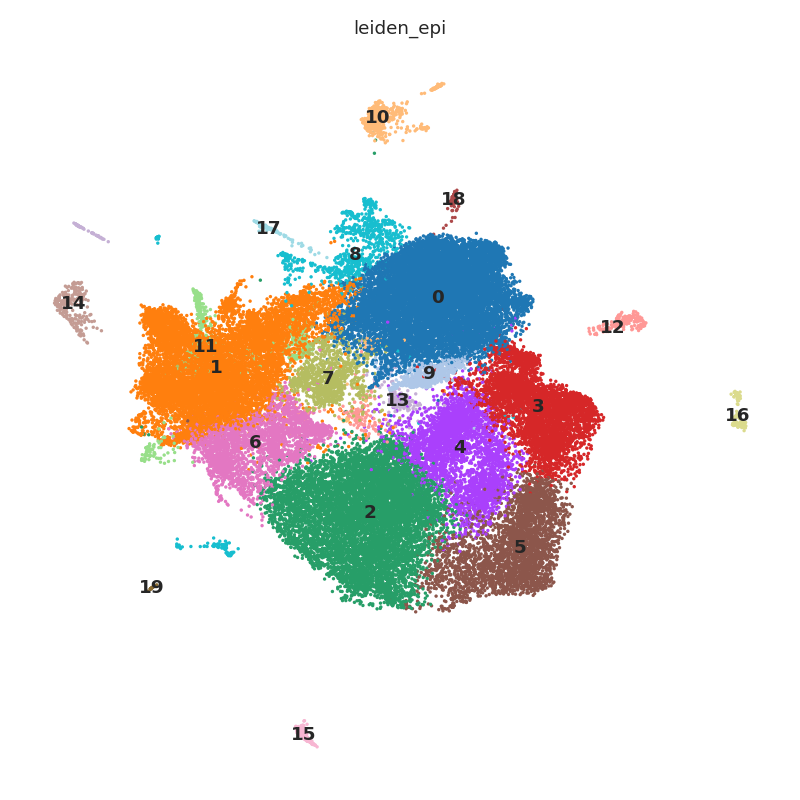

In [8]:
sns.set_theme(style='white',palette='Accent',font_scale=0.55,rc={
    'xtick.bottom': True,
    'ytick.left': True}
)

# Create subplots in a two-column layout
fig, ax = plt.subplots(figsize=(4,4),dpi=200)

sc.pl.umap(
    adata,
    color='leiden_epi',
    #color='sample',
    size=6,
    frameon=False,
    legend_loc='on data',
    show=False,
    colorbar_loc=None,
    ax=ax
)

ax.invert_xaxis()

# Save as modifiable PDF
plt.tight_layout()
#plt.savefig('/home/ak431480/plots/lyu_scs_data_lineage_scores_umap_t_cells.pdf', format='pdf',dpi=300)
plt.show()


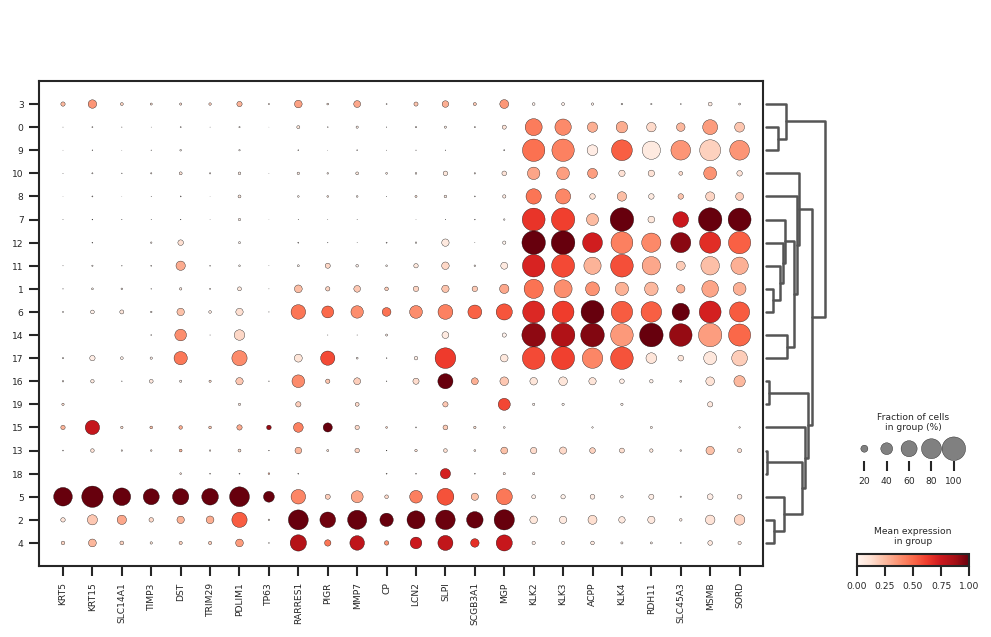

In [9]:
annotation_genes = [
    'KRT5', 'KRT15', 'SLC14A1', 'TIMP3', 'DST', 'TRIM29', 'PDLIM1', 'TP63', # Basal
    'RARRES1', 'PIGR', 'MMP7', 'CP', 'LCN2', 'SLPI', 'SCGB3A1', 'MGP', # Duct luminal
    'KLK2', 'KLK3', 'ACPP', 'KLK4', 'RDH11', 'SLC45A3', 'MSMB', 'SORD' # Luminal
]


#adata.obs['myeloid_annotation'] = pd.Categorical(adata.obs['leiden_tcell'].map(cluster_mapping),categories = cat_order)
adata.obs['epi_annotation'] = adata.obs['leiden_epi'].copy()

fig, ax = plt.subplots(figsize=(10,6),dpi=120)
sc.pl.dotplot(adata,
var_names=annotation_genes,
groupby='leiden_epi',
layer='log1p',
dendrogram=True,
ax=ax,
show=False,
standard_scale='var',
var_group_rotation=30)
plt.show()

### Celltype fractions across sample types

In [10]:
epi_cluster_pct = compute_cell_type_percentages(adata,'leiden_epi')
print_pvalues(epi_cluster_pct)

Successfully created percentage dataframe
0
PC vs HSPC: p = 0.0000 ***
PC vs CRPC: p = 0.0149 *
HSPC vs CRPC: p = 0.0358 *

1
PC vs HSPC: p = 0.0837
PC vs CRPC: p = 0.0610
HSPC vs CRPC: p = 0.0251 *

2
PC vs HSPC: p = 0.0192 *
PC vs CRPC: p = 1.0000
HSPC vs CRPC: p = 0.1790

3
PC vs HSPC: p = 0.0279 *
PC vs CRPC: p = 0.0394 *
HSPC vs CRPC: p = 0.0009 ***

4
PC vs HSPC: p = 0.0035 **
PC vs CRPC: p = 0.2061
HSPC vs CRPC: p = 0.0017 **

5
PC vs HSPC: p = 0.0049 **
PC vs CRPC: p = 0.2234
HSPC vs CRPC: p = 0.0438 *

6
PC vs HSPC: p = 0.0192 *
PC vs CRPC: p = 0.0192 *
HSPC vs CRPC: p = 0.1236

7
PC vs HSPC: p = 0.0000 ***
PC vs CRPC: p = 0.0020 **
HSPC vs CRPC: p = 0.6143

8
PC vs HSPC: p = 0.3871
PC vs CRPC: p = 0.8514
HSPC vs CRPC: p = 0.5017

9
PC vs HSPC: p = 0.0022 **
PC vs CRPC: p = 0.0087 **
HSPC vs CRPC: p = 0.1306

10
PC vs HSPC: p = 0.1444
PC vs CRPC: p = 0.6065
HSPC vs CRPC: p = 0.1106

11
PC vs HSPC: p = 0.0211 *
PC vs CRPC: p = 0.3490
HSPC vs CRPC: p = 0.5756

12
PC vs HSPC: p =

/tmp/ipykernel_1355855/4197354004.py:61: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_sub[group_col]):


/tmp/ipykernel_1355855/2713162126.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)


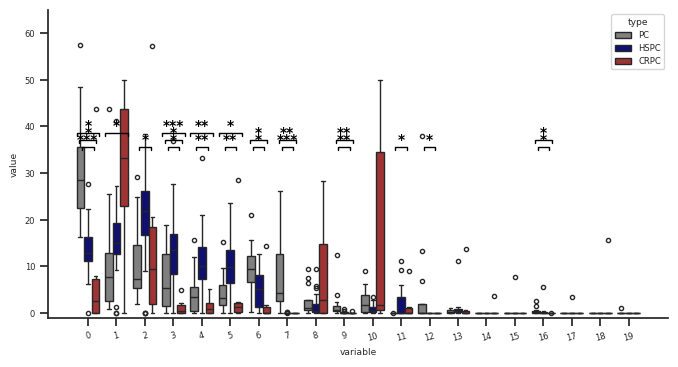

In [11]:
# Set theme
sns.set_theme(style='white', palette='tab10', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True}
)

# Prepare data
plot_df = epi_cluster_pct.set_index('type').melt(ignore_index=False).reset_index(drop=False)

# Create plotb
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(plot_df,
            x='variable',
            y='value',
            hue='type',
            ax=ax,
            fliersize=3,
            flierprops={"marker": "o"},
            palette=sns.color_palette(['gray', 'navy', 'firebrick']),
            )

ax.set_ylim(-1, 65)
ax.spines[['top', 'right']].set_visible(False)

# Add significance markers
for i, ctype in enumerate(plot_df['variable'].unique()):
    df = plot_df[plot_df['variable'] == ctype]
    for j, (g1, g2) in enumerate(combinations(df['type'].cat.categories, 2)):
        stat, pval = ranksums(df[df['type'] == g1]['value'],
                              df[df['type'] == g2]['value'])
        marker = significance_marker(pval)
        if marker:
            x1 = i - 0.2 - j * 0.1
            x2 = i + 0.2 + j * 0.1
            y = 35 + j*1.5
            h = 0.5
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c='black')
            ax.text((x1 + x2) / 2, y + h + 0.2, marker, ha='center', va='bottom',fontdict={'weight':'bold'}, color='black',size=10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
plt.show()

In [12]:
sc.tl.rank_genes_groups(adata,groupby='leiden_epi',groups='all',layer='log1p',use_raw=False)
deg_df = sc.get.rank_genes_groups_df(adata, group=None,log2fc_min=0.5,pval_cutoff=0.05)

In [13]:
# Save the df
epi_cluster_pct.drop(columns='type').to_csv(f'./Epithelial_cluster_percentages_{formatted_date}.csv')
adata.obs.to_csv(f'./Epithelial_obs_data_{formatted_date}.csv')
deg_df.to_csv(f'./Epithelial_degs_{formatted_date}.csv')

## T cells

### Clustering and cluster annotation

In [238]:
adata = adata_concat[adata_concat.obs['cell_type'] == 'T cell'].copy()

print('Creating neighborhood graph...')
sc.pp.neighbors(adata, use_rep='X_pca_harmony',random_state=3155633)

print('Clustering...')
# Leiden clustering
sc.tl.leiden(adata, resolution=clustering_resolution,key_added='leiden_tcell',random_state=4832314)

print('Creating UMAP...')
# UMAP visualization
sc.tl.umap(adata)

adata

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating neighborhood graph...
Clustering...
Creating UMAP...


AnnData object with n_obs × n_vars = 60136 × 26261
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'Basal', 'Ductal luminal', 'Luminal', 'B1_Basal-ESR1', 'B2_Basal', 'B3_Basal-GPRC5A', 'B4_Basal', 'B5_Basal-VCAN', 'B6_Basal-IC1', 'd1_dLum-Club', 'd2_dLum-KRT4', 'd3_dLum-LTF', 'd4_dLum-NKX3-1', 'd5_dLum', 'd6_dLum-CNMD', 'Lum−LTF', 'Lum−SFTPA2', 'Lum−TGM4', 'Lum−type1', 'Lum−type2', 'BPECT Luminal Identity', 'BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity', 'CRPC-AR', 'CRPC-WNT', 'CRPC-NE', 'CRPC-SCL', 'JAK_STAT_FGFR', 'IL1B MDSCs', 'PMN-MDSCs', 'B1_Basal-ESR1_d1_dLum-Club', 'Basal_B1_Basal-ESR1', 'Ductal_luminal_dLum-Club', 'TISS', 'leiden_tcell'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogra

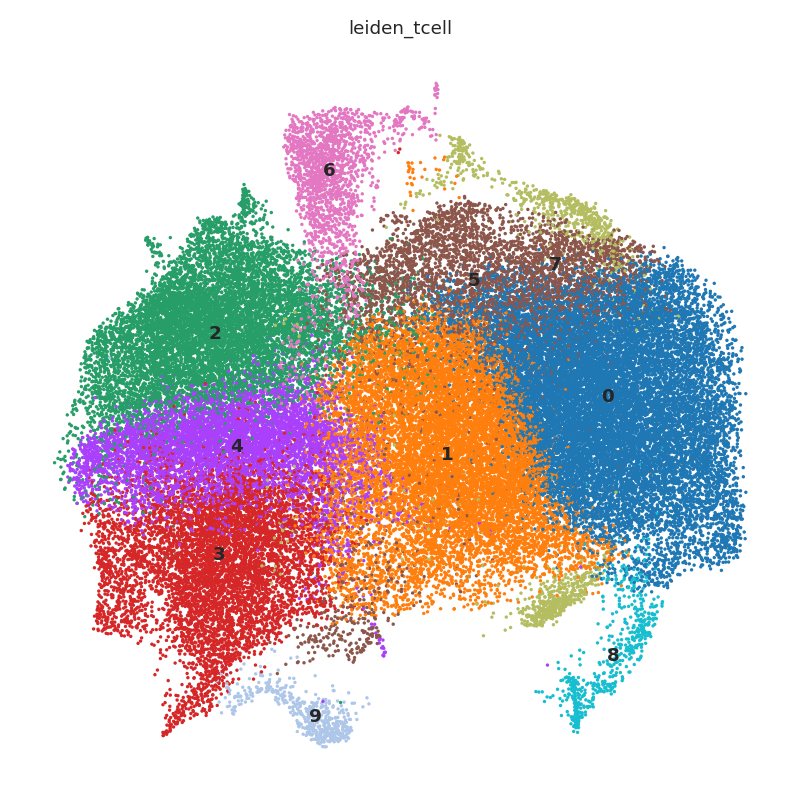

In [239]:
sns.set_theme(style='white',palette='Accent',font_scale=0.55,rc={
    'xtick.bottom': True,
    'ytick.left': True}
)

# Create subplots in a two-column layout
fig, ax = plt.subplots(figsize=(4,4),dpi=200)

sc.pl.umap(
    adata,
    color='leiden_tcell',
    #color='sample',
    size=6,
    frameon=False,
    legend_loc='on data',
    show=False,
    colorbar_loc=None,
    ax=ax
)

ax.invert_xaxis()

# Save as modifiable PDF
plt.tight_layout()
#plt.savefig('/home/ak431480/plots/lyu_scs_data_lineage_scores_umap_t_cells.pdf', format='pdf',dpi=300)
plt.show()


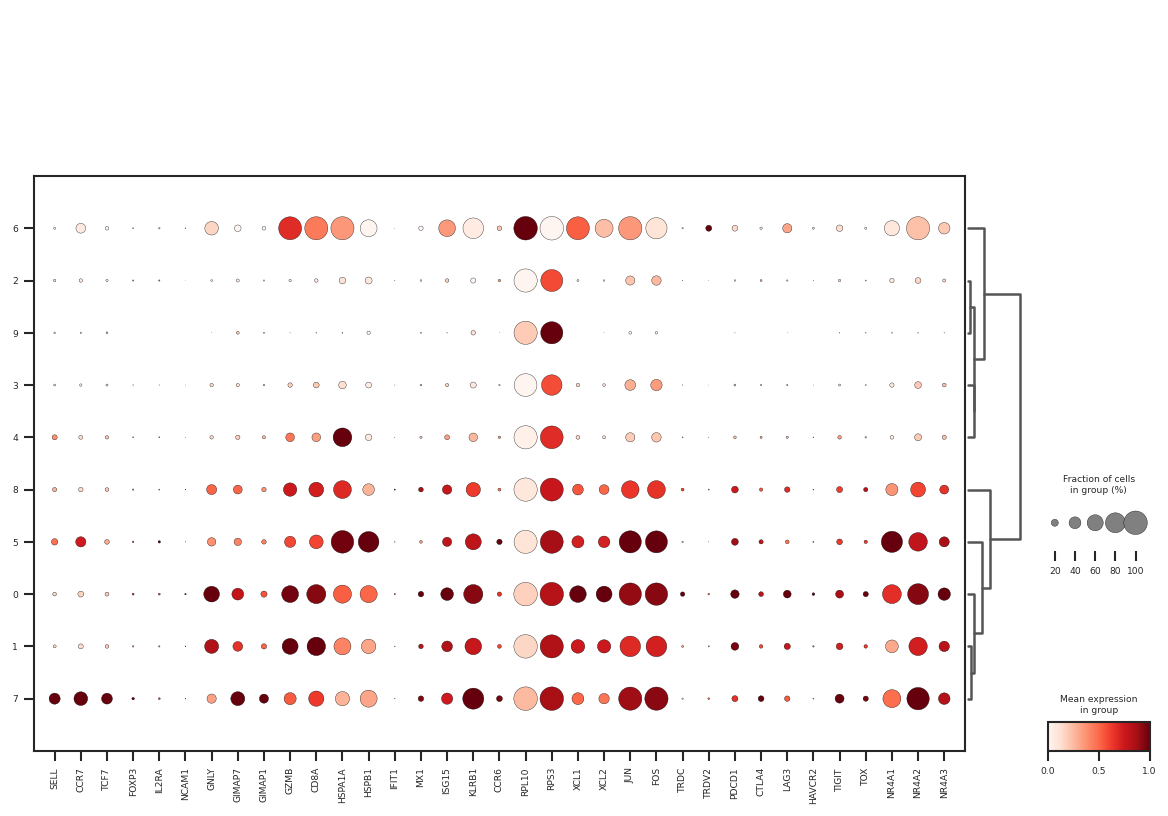

In [240]:
annotation_genes = ['SELL', 'CCR7', 'TCF7', 'FOXP3', 'IL2RA', 'NCAM1', 'GNLY', 'GIMAP7', 'GIMAP1', 'GZMB', 'CD8A', 'HSPA1A', 'HSPB1', 'IFIT1', 'MX1', 'ISG15', 'KLRB1', 'CCR6', 'RPL10', 'RPS3', 'XCL1', 'XCL2', 'JUN', 'FOS', 'TRDC', 'TRDV2', 'PDCD1', 'CTLA4', 'LAG3', 'HAVCR2', 'TIGIT', 'TOX', 'NR4A1', 'NR4A2', 'NR4A3']


#adata.obs['myeloid_annotation'] = pd.Categorical(adata.obs['leiden_tcell'].map(cluster_mapping),categories = cat_order)
adata.obs['tcell_annotation'] = adata.obs['leiden_tcell'].copy()

fig, ax = plt.subplots(figsize=(12,8),dpi=120)
sc.pl.dotplot(adata,
var_names=annotation_genes,
groupby='leiden_tcell',
layer='log1p',
dendrogram=True,
ax=ax,
show=False,
standard_scale='var',
var_group_rotation=30)
plt.show()

### Celltype fractions across sample types

In [241]:
tcell_cluster_pct = compute_cell_type_percentages(adata,'leiden_tcell')
print_pvalues(tcell_cluster_pct)

Successfully created percentage dataframe
0
PC vs HSPC: p = 0.8975
PC vs CRPC: p = 0.3149
HSPC vs CRPC: p = 0.4840

1
PC vs HSPC: p = 0.4959
PC vs CRPC: p = 0.7630
HSPC vs CRPC: p = 0.1783

2
PC vs HSPC: p = 0.0030 **
PC vs CRPC: p = 0.0159 *
HSPC vs CRPC: p = 0.7063

3
PC vs HSPC: p = 0.0489 *
PC vs CRPC: p = 0.3657
HSPC vs CRPC: p = 0.1963

4
PC vs HSPC: p = 0.6991
PC vs CRPC: p = 0.1914
HSPC vs CRPC: p = 0.1460

5
PC vs HSPC: p = 0.0001 ***
PC vs CRPC: p = 0.0159 *
HSPC vs CRPC: p = 0.0464 *

6
PC vs HSPC: p = 0.2315
PC vs CRPC: p = 0.4510
HSPC vs CRPC: p = 0.0526

7
PC vs HSPC: p = 0.3479
PC vs CRPC: p = 0.1914
HSPC vs CRPC: p = 0.9143

8
PC vs HSPC: p = 0.3479
PC vs CRPC: p = 0.4817
HSPC vs CRPC: p = 0.5903

9
PC vs HSPC: p = 0.5436
PC vs CRPC: p = 0.5465
HSPC vs CRPC: p = 0.8717



/tmp/ipykernel_1340681/4197354004.py:61: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_sub[group_col]):


/tmp/ipykernel_1340681/623156372.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)


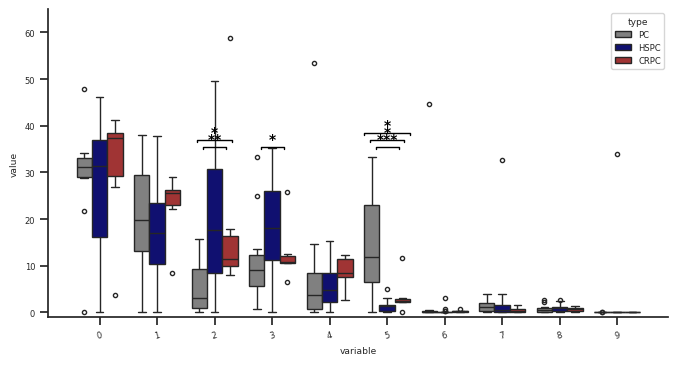

In [242]:
# Set theme
sns.set_theme(style='white', palette='tab10', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True}
)

# Prepare data
plot_df = tcell_cluster_pct.set_index('type').melt(ignore_index=False).reset_index(drop=False)

# Create plotb
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(plot_df,
            x='variable',
            y='value',
            hue='type',
            ax=ax,
            fliersize=3,
            flierprops={"marker": "o"},
            palette=sns.color_palette(['gray', 'navy', 'firebrick']),
            )

ax.set_ylim(-1, 65)
ax.spines[['top', 'right']].set_visible(False)

# Function to determine significance level
def significance_marker(pval):
    if pval < 0.001:
        return '***'
    elif pval < 0.01:
        return '**'
    elif pval < 0.05:
        return '*'
    else:
        return None

# Add significance markers
for i, ctype in enumerate(plot_df['variable'].unique()):
    df = plot_df[plot_df['variable'] == ctype]
    for j, (g1, g2) in enumerate(combinations(df['type'].cat.categories, 2)):
        stat, pval = ranksums(df[df['type'] == g1]['value'],
                              df[df['type'] == g2]['value'])
        marker = significance_marker(pval)
        if marker:
            x1 = i - 0.2 - j * 0.1
            x2 = i + 0.2 + j * 0.1
            y = 35 + j*1.5
            h = 0.5
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c='black')
            ax.text((x1 + x2) / 2, y + h + 0.2, marker, ha='center', va='bottom',fontdict={'weight':'bold'}, color='black',size=10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
plt.show()

In [243]:
sc.tl.rank_genes_groups(adata,groupby='leiden_tcell',groups='all',layer='log1p',use_raw=False)
deg_df = sc.get.rank_genes_groups_df(adata, group=None,log2fc_min=0.5,pval_cutoff=0.05)


In [244]:
# Save the df
tcell_cluster_pct.drop(columns='type').to_csv(f'./Tcell_cluster_percentages_{formatted_date}.csv')
adata.obs.to_csv(f'./Tcell_obs_data_{formatted_date}.csv')
deg_df.to_csv(f'./Tcell_degs_{formatted_date}.csv')

## Myeloid cells

### Clustering and cluster annotation

In [46]:
adata = adata_concat[adata_concat.obs['cell_type'] == 'Myeloid cell'].copy()

print('Creating neighborhood graph...')
sc.pp.neighbors(adata, use_rep='X_pca_harmony',random_state=15228)

print('Clustering...')
# Leiden clustering
sc.tl.leiden(adata, resolution=clustering_resolution,key_added='leiden_myeloid',random_state=485265)

print('Creating UMAP...')
# UMAP visualization
sc.tl.umap(adata)

adata

/home/ak431480/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Creating neighborhood graph...
Clustering...
Creating UMAP...


AnnData object with n_obs × n_vars = 14039 × 26261
    obs: 'doublet', 'doublet_score', 'sample', 'type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type', 'Basal', 'Ductal luminal', 'Luminal', 'B1_Basal-ESR1', 'B2_Basal', 'B3_Basal-GPRC5A', 'B4_Basal', 'B5_Basal-VCAN', 'B6_Basal-IC1', 'd1_dLum-Club', 'd2_dLum-KRT4', 'd3_dLum-LTF', 'd4_dLum-NKX3-1', 'd5_dLum', 'd6_dLum-CNMD', 'Lum−LTF', 'Lum−SFTPA2', 'Lum−TGM4', 'Lum−type1', 'Lum−type2', 'BPECT Luminal Identity', 'BPECT Basal Identity', 'BPECT Club Identity', 'BPECT Hillock Identity', 'CRPC-AR', 'CRPC-WNT', 'CRPC-NE', 'CRPC-SCL', 'JAK_STAT_FGFR', 'IL1B MDSCs', 'PMN-MDSCs', 'B1_Basal-ESR1_d1_dLum-Club', 'Basal_B1_Basal-ESR1', 'Ductal_luminal_dLum-Club', 'TISS', 'leiden_myeloid'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrog

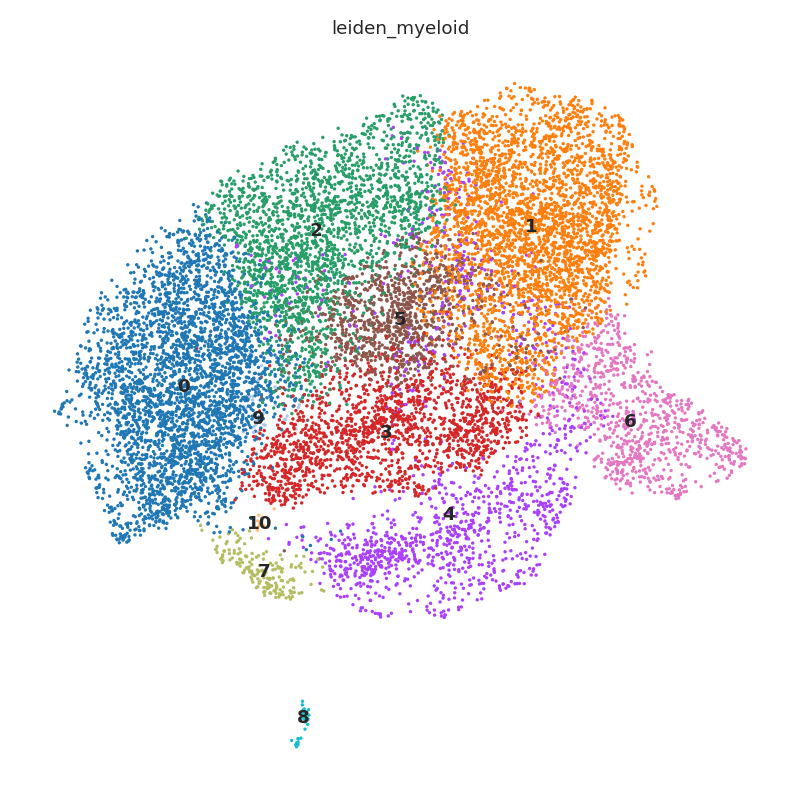

In [47]:
sns.set_theme(style='white',palette='Accent',font_scale=0.55,rc={
    'xtick.bottom': True,
    'ytick.left': True}
)

# Create subplots in a two-column layout
fig, ax = plt.subplots(figsize=(4,4),dpi=200)

sc.pl.umap(
    adata,
    color='leiden_myeloid',
    #color='type',
    size=6,
    frameon=False,
    legend_loc='on data',
    show=False,
    colorbar_loc=None,
    ax=ax
)

ax.invert_xaxis()

# Save as modifiable PDF
plt.tight_layout()
plt.savefig('/home/ak431480/plots/lyu_scs_data_lineage_scores_umap_epithelial_cells.pdf', dpi=300)
plt.show()


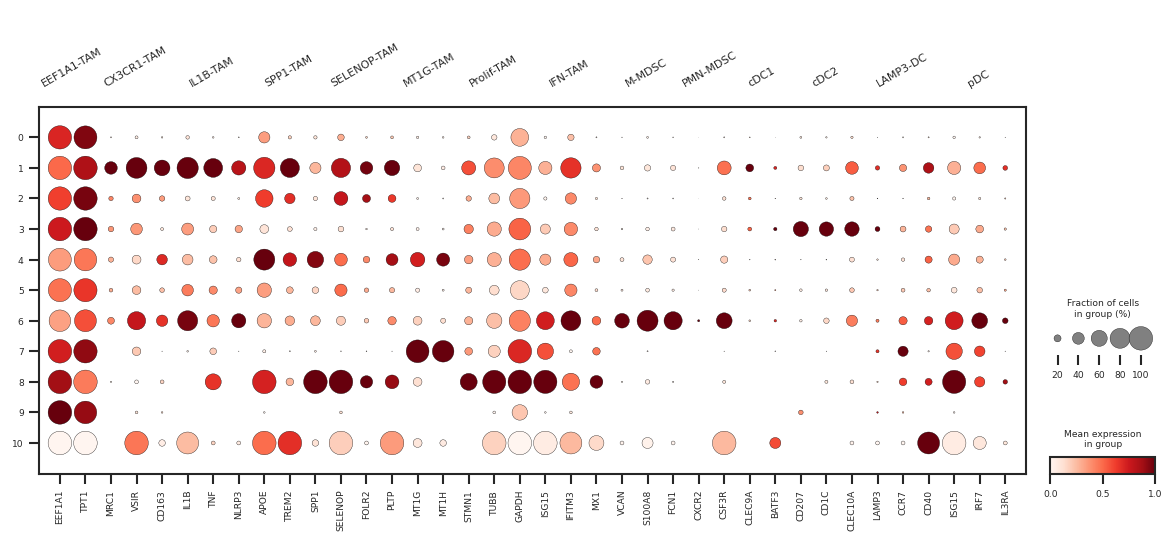

In [48]:
annotation_genes = {
    'EEF1A1-TAM':['EEF1A1','TPT1'],
    'CX3CR1-TAM':['MRC1','VSIR','CD163'],
    'IL1B-TAM':['IL1B','TNF','NLRP3'],
    'SPP1-TAM':['APOE','TREM2','SPP1'],
    'SELENOP-TAM':['SELENOP','FOLR2','PLTP'],
    'MT1G-TAM':['MT1G','MT1H'],
    'Prolif-TAM':['STMN1','TUBB','GAPDH'],
    'IFN-TAM':['ISG15','IFITM3','MX1'],
    'M-MDSC':['VCAN','S100A8','FCN1'],
    'PMN-MDSC':['CXCR2','CSF3R'],
    'cDC1':['CLEC9A','BATF3'],
    'cDC2':['CD207','CD1C','CLEC10A'],
    'LAMP3-DC':['LAMP3','CCR7','CD40'],
    'pDC':['ISG15','IRF7','IL3RA'],
}


cluster_mapping = {
    '0':'EEF1A1-TAM',
    '1':'cDC2',
    '2':'SELENOP-TAM',
    '3':'cDC1',
    '4':'IL1B-TAM',
    '5':'SPP1-TAM',
    '6':'Prolif-TAM',
    '7':'CX3CR1-TAM',
    '8':'IL1B-TAM',
    '9':'IFN-TAM',
    '10':'MT1G-TAM',
    '11':'SPP1-TAM',
    '12':'M-MDSC',
    '13':'PMN-MDSC',
    '14':'LAMP3-DC',
    '15':'SPP1-TAM',
    '16':'pDC',
    '17':'SPP1-TAM'
}
cat_order = ['EEF1A1-TAM',
'CX3CR1-TAM',
'IL1B-TAM',
'SPP1-TAM',
'SELENOP-TAM',
'MT1G-TAM',
'Prolif-TAM',
'IFN-TAM',
'M-MDSC',
'PMN-MDSC',
'cDC1',
'cDC2',
'LAMP3-DC',
'pDC']

#adata.obs['myeloid_annotation'] = pd.Categorical(adata.obs['leiden_myeloid'].map(cluster_mapping),categories = cat_order)
adata.obs['myeloid_annotation'] = adata.obs['leiden_myeloid'].copy()

fig, ax = plt.subplots(figsize=(12,5),dpi=120)
sc.pl.dotplot(adata,
var_names=annotation_genes,
groupby='myeloid_annotation',
layer='log1p',
ax=ax,
show=False,
standard_scale='var',
var_group_rotation=30)
plt.show()

### Celltype fractions across sample types

In [49]:
myeloid_cluster_pct = compute_cell_type_percentages(adata,'leiden_myeloid')
print_pvalues(myeloid_cluster_pct)

Successfully created percentage dataframe
0
PC vs HSPC: p = 0.1462
PC vs CRPC: p = 0.8608
HSPC vs CRPC: p = 0.3507

1
PC vs HSPC: p = 0.0054 **
PC vs CRPC: p = 0.2729
HSPC vs CRPC: p = 0.3507

2
PC vs HSPC: p = 0.0012 **
PC vs CRPC: p = 0.9650
HSPC vs CRPC: p = 0.0442 *

3
PC vs HSPC: p = 0.6578
PC vs CRPC: p = 0.5987
HSPC vs CRPC: p = 0.4483

4
PC vs HSPC: p = 0.1320
PC vs CRPC: p = 0.1605
HSPC vs CRPC: p = 0.8611

5
PC vs HSPC: p = 0.0492 *
PC vs CRPC: p = 0.3805
HSPC vs CRPC: p = 0.9071

6
PC vs HSPC: p = 0.0039 **
PC vs CRPC: p = 0.2542
HSPC vs CRPC: p = 0.0267 *

7
PC vs HSPC: p = 0.0534
PC vs CRPC: p = 0.0655
HSPC vs CRPC: p = 0.5997

8
PC vs HSPC: p = 1.0000
PC vs CRPC: p = 0.5686
HSPC vs CRPC: p = 0.5403

9
PC vs HSPC: p = 0.8178
PC vs CRPC: p = 1.0000
HSPC vs CRPC: p = 0.8611

10
PC vs HSPC: p = 0.9294
PC vs CRPC: p = 0.7925
HSPC vs CRPC: p = 0.7264



/tmp/ipykernel_1355855/4197354004.py:61: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df_sub[group_col]):


/tmp/ipykernel_1355855/1877303522.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=15)


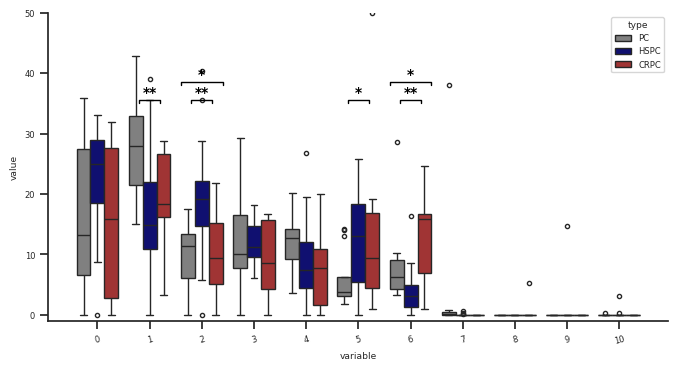

In [50]:
# Set theme
sns.set_theme(style='white', palette='tab10', font_scale=0.55, rc={
    'xtick.bottom': True,
    'ytick.left': True}
)

# Prepare data
plot_df = myeloid_cluster_pct.set_index('type').melt(ignore_index=False).reset_index(drop=False)

# Create plot
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(plot_df,
            x='variable',
            y='value',
            hue='type',
            ax=ax,
            fliersize=3,
            flierprops={"marker": "o"},
            palette=sns.color_palette(['gray', 'navy', 'firebrick']),
            )

ax.set_ylim(-1, 50)
ax.spines[['top', 'right']].set_visible(False)

# Add significance markers
for i, ctype in enumerate(plot_df['variable'].unique()):
    df = plot_df[plot_df['variable'] == ctype]
    for j, (g1, g2) in enumerate(combinations(df['type'].cat.categories, 2)):
        stat, pval = ranksums(df[df['type'] == g1]['value'],
                              df[df['type'] == g2]['value'])
        marker = significance_marker(pval)
        if marker:
            x1 = i - 0.2 - j * 0.1
            x2 = i + 0.2 + j * 0.1
            y = 35 + j*1.5
            h = 0.5
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c='black')
            ax.text((x1 + x2) / 2, y + h + 0.2, marker, ha='center', va='bottom',fontdict={'weight':'bold'}, color='black',size=10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=15)
plt.show()

In [51]:
sc.tl.rank_genes_groups(adata,groupby='leiden_myeloid',groups='all',layer='log1p',use_raw=False)
deg_df = sc.get.rank_genes_groups_df(adata, group=None,log2fc_min=0.5,pval_cutoff=0.05)

In [52]:
# Save the df
myeloid_cluster_pct.drop(columns='type').to_csv(f'./Myeloid_cluster_percentages_{formatted_date}.csv')
adata.obs.to_csv(f'./Myeloid_obs_data_{formatted_date}.csv')
deg_df.to_csv(f'./Myeloid_degs_{formatted_date}.csv')

## Compare fractions across celltypes

In [136]:
# Min fraction
min_fraction = 0.05

# Epithelial cells
epi_cluster_pct = pd.read_csv('./Epithelial_cluster_percentages_250814.csv',index_col=0)
epi_cluster_pct.columns = ['Epithelial_' + c for c in epi_cluster_pct.columns]
epi_cluster_pct = epi_cluster_pct[epi_cluster_pct.loc['total_n'][epi_cluster_pct.loc['total_n'] / epi_cluster_pct.loc['total_n'].sum() >= min_fraction].index]

# T cells
tcell_cluster_pct = pd.read_csv('./Tcell_cluster_percentages_250814.csv',index_col=0)
tcell_cluster_pct.columns = ['Tcell_' + c for c in tcell_cluster_pct.columns]
tcell_cluster_pct = tcell_cluster_pct[tcell_cluster_pct.loc['total_n'][tcell_cluster_pct.loc['total_n'] / tcell_cluster_pct.loc['total_n'].sum() >= min_fraction].index]

# Myeloid cells
myeloid_cluster_pct = pd.read_csv('./Myeloid_cluster_percentages_250814.csv',index_col=0)
myeloid_cluster_pct.columns = ['Myeloid_' + c for c in myeloid_cluster_pct.columns]
myeloid_cluster_pct = myeloid_cluster_pct[myeloid_cluster_pct.loc['total_n'][myeloid_cluster_pct.loc['total_n'] / myeloid_cluster_pct.loc['total_n'].sum() >= min_fraction].index]

total_cluster_pcts = pd.concat([epi_cluster_pct,tcell_cluster_pct,myeloid_cluster_pct],axis=1)

total_cluster_pcts = total_cluster_pcts.dropna().drop('total_n')
total_cluster_pcts


,Epithelial_0,Epithelial_1,Epithelial_2,Epithelial_3,Epithelial_4,Epithelial_5,Epithelial_6,Tcell_0,Tcell_1,Tcell_2,Tcell_3,Tcell_4,Tcell_5,Myeloid_0,Myeloid_1,Myeloid_2,Myeloid_3,Myeloid_4,Myeloid_5,Myeloid_6
sample,,,,,,,,,,,,,,,,,,,,
CRPC_S01,0.000000,27.272727,0.000000,0.000000,0.000000,0.000000,0.000000,38.112306,22.222222,8.124253,6.451613,12.305854,11.708483,11.428571,28.831169,7.532468,4.415584,20.000000,3.116883,24.675325
CRPC_S02,0.000000,0.000000,57.142857,0.000000,0.000000,28.571429,14.285714,41.216216,25.675676,9.909910,10.585586,7.432432,2.252252,0.000000,82.608696,4.347826,0.000000,0.000000,8.695652,4.347826
CRPC_S03,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.718750,26.562500,10.351562,12.500000,8.984375,3.125000,0.000000,16.666667,0.000000,16.666667,0.000000,50.000000,16.666667
CRPC_S04,8.000000,21.411765,20.705882,4.941176,5.176471,1.882353,1.647059,26.883910,29.022403,17.820774,11.099796,12.219959,2.545825,30.000000,3.333333,16.666667,16.666667,6.666667,10.000000,16.666667
CRPC_S05,43.799342,39.292763,7.434211,0.723684,1.595395,0.608553,0.164474,3.647289,8.524315,58.887647,25.908329,2.613192,0.013974,20.190476,16.000000,21.904762,12.857143,8.952381,19.142857,0.952381
CRPC_S06,5.394191,45.228216,11.618257,2.074689,2.489627,2.282158,0.000000,38.546845,25.736138,12.390057,10.669216,8.068834,2.179732,31.865585,20.046350,11.123986,4.287370,11.471611,1.042874,14.947856
HSPC_S08,10.061602,13.963039,24.229979,12.936345,6.981520,17.043121,0.616016,12.096774,12.500000,29.435484,26.612903,15.322581,1.612903,26.829268,0.000000,14.634146,7.317073,26.829268,21.951220,2.439024
HSPC_S09,22.222222,0.000000,0.000000,27.777778,33.333333,0.000000,0.000000,17.567568,4.054054,35.135135,27.027027,13.513514,0.000000,14.516129,9.677419,40.322581,8.064516,1.612903,25.806452,0.000000
HSPC_S10,14.887769,11.131470,20.384792,14.200641,14.612918,16.262025,6.825470,36.374550,25.690276,15.966387,10.144058,4.741897,2.400960,24.859813,11.775701,19.439252,14.953271,12.336449,13.457944,3.177570


/tmp/ipykernel_1355855/2444517673.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = corrected_pval_matrix.applymap(significance_marker)


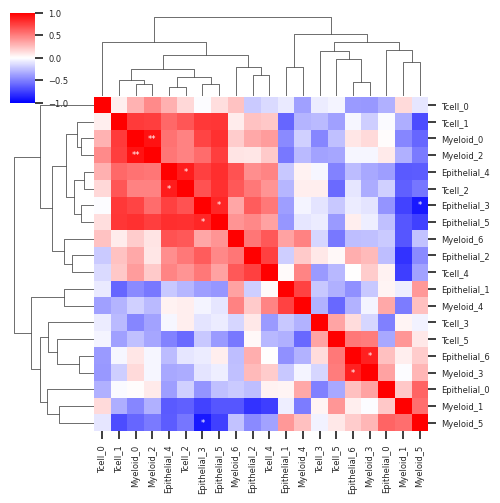

/tmp/ipykernel_1355855/2444517673.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_matrix = corrected_pval_matrix.applymap(significance_marker)


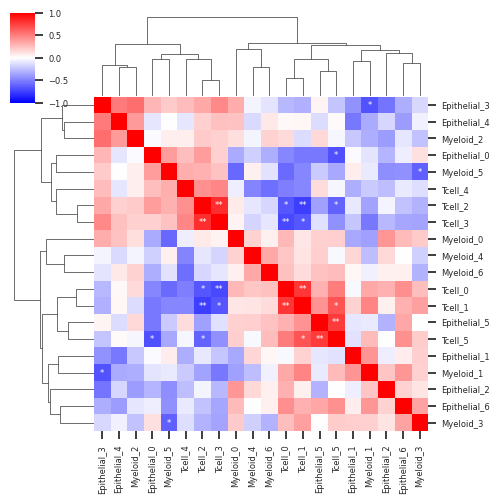

In [119]:

for sampletype in ['^PC_','HSPC']:
    df = total_cluster_pcts.loc[total_cluster_pcts.index.str.contains(sampletype)]

    corr_matrix = pd.DataFrame(np.zeros((df.shape[1], df.shape[1])),
                            index=df.columns, columns=df.columns)
    pval_matrix = pd.DataFrame(np.ones(corr_matrix.shape),
                            index=df.columns, columns=df.columns)

    for i in range(len(df.columns)):
        for j in range(i, len(df.columns)):
            col1 = df.columns[i]
            col2 = df.columns[j]
            corr, pval = spearmanr(df[col1], df[col2])
            corr_matrix.loc[col1, col2] = corr
            corr_matrix.loc[col2, col1] = corr
            pval_matrix.loc[col1, col2] = pval
            pval_matrix.loc[col2, col1] = pval

    # Flatten p-values and apply FDR correction
    flat_pvals = pval_matrix.values[np.triu_indices_from(pval_matrix, k=1)]
    _, corrected_pvals, _, _ = multipletests(flat_pvals, method='fdr_bh')

    # Create corrected p-value matrix
    corrected_pval_matrix = pd.DataFrame(np.ones(corr_matrix.shape),
                                        index=corr_matrix.index, columns=corr_matrix.columns)
    idx = 0
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            corrected_pval_matrix.iloc[i, j] = corrected_pvals[idx]
            corrected_pval_matrix.iloc[j, i] = corrected_pvals[idx]
            idx += 1

    # Create annotation matrix
    annot_matrix = corrected_pval_matrix.applymap(significance_marker)
    annot_matrix = annot_matrix.fillna('')

    # Plot clustermap with annotations
    sns.set_theme(style='white', palette='Accent', font_scale=0.55, rc={
        'xtick.bottom': True,
        'ytick.left': True}
    )

    sns.clustermap(corr_matrix, figsize=(5, 5), vmin=-1, vmax=1, cmap='bwr',
                annot=annot_matrix, fmt='', annot_kws={"size": 6})

    plt.show()


### Differentially expressed genes

In [15]:
tcell_degs = pd.read_csv('./Tcell_degs_250814.csv',index_col=0)
epi_degs = pd.read_csv('./Epithelial_degs_250814.csv',index_col=0)
myeloid_degs = pd.read_csv('./Myeloid_degs_250814.csv',index_col=0)

In [135]:
genes = gene_modules_dict['TISS']
#genes = ['LTF']#,'FOS','JUN']
epi_degs[epi_degs['names'].isin(genes)].sort_values('scores',ascending=False)['group'].value_counts()
#epi_degs[epi_degs['names'].isin(genes)].sort_values('scores',ascending=False)
#epi_degs[epi_degs['group'].isin([5])].sort_values('scores',ascending=False)[:20]

group
2     66
5     57
6     34
4     24
17    23
12    16
15    15
14    10
11     8
16     8
3      5
13     3
9      1
1      1
10     1
7      1
18     1
Name: count, dtype: int64

In [151]:
#genes = ['PDCD1','CTLA4','LAG3','HAVCR2','BTLA','TIGIT','TOX']
#genes = ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'PRF1', 'GNLY', 'IFNG', 'NKG7', 'CXCR3', 'TBX21', 'EOMES', 'IL2RB', 'KLRG1', 'LAMP1', 'FASLG', 'CCR5', 'STAT1', 'STAT4']
genes = ['CD4A','SELL','FOXP3','IL2RA']

#tcell_degs[tcell_degs['names'].isin(genes)].sort_values('scores',ascending=False)
#tcell_degs[tcell_degs['names'].isin(genes)]['group'].value_counts()/len(genes)

,group,names,scores,logfoldchanges,pvals,pvals_adj
8095,0,FOXP3,7.382176,0.669234,1.604735e-13,5.066356e-13
9027,0,IL2RA,6.084297,0.540468,1.185855e-09,3.348574e-09
18988,4,SELL,13.340931,1.030607,4.544218e-40,6.604079e-39
19412,5,SELL,16.488775,1.360903,2.363703e-59,1.440214e-57
19968,5,IL2RA,7.935677,1.240910,2.625977e-15,5.387562e-14
21735,7,SELL,20.415247,2.549785,2.052738e-80,2.026577e-78
25308,7,FOXP3,4.185257,1.080007,3.041009e-05,1.467744e-04


In [154]:
tcell_degs[tcell_degs['group'].isin([5])].sort_values('scores',ascending=False)[:30]

,group,names,scores,logfoldchanges,pvals,pvals_adj
19022,5,HSP90AA1,141.864580,3.789468,0.0,0.0
19023,5,DNAJB1,140.207090,4.208731,0.0,0.0
19024,5,HSPA8,131.269300,2.972513,0.0,0.0
19025,5,HSPH1,120.170140,4.133690,0.0,0.0
19026,5,HSPA1B,118.280510,4.462147,0.0,0.0
19027,5,MALAT1,111.821290,1.891640,0.0,0.0
19028,5,DNAJA1,110.500114,3.073229,0.0,0.0
19029,5,HSP90AB1,108.574580,2.729200,0.0,0.0
19030,5,HSPD1,107.146430,3.642874,0.0,0.0
19031,5,HSPE1,106.797745,3.440497,0.0,0.0


In [126]:
#genes = ['CEBPB','CXCL1','CXCL2','CXCL8','PLAUR','CD68','IL1RN','NFKB1','CXCR2','CXCR1','S100A8','S100A9']
genes = gene_modules_dict['PMN-MDSCs']
#genes = gene_modules_dict['IL1B MDSCs']

#myeloid_degs[myeloid_degs['names'].isin(genes)]
myeloid_degs[myeloid_degs['group'].isin([2])][:20]

,group,names,scores,logfoldchanges,pvals,pvals_adj
12745,2,C1QA,61.395930,2.321264,0.000000e+00,0.000000e+00
12746,2,C1QB,57.752780,2.334457,0.000000e+00,0.000000e+00
12747,2,C1QC,56.231003,2.299684,0.000000e+00,0.000000e+00
12748,2,HLA-DPA1,40.304207,1.431361,1.964679e-303,2.715497e-300
12749,2,CD74,37.986603,1.343495,1.490831e-269,1.262926e-266
12750,2,HLA-DRB1,36.755030,1.426257,1.888508e-257,1.340381e-254
12751,2,CST3,35.718300,1.192444,6.138243e-248,4.133241e-245
12752,2,HLA-DRA,35.045680,1.256374,3.087205e-236,1.842570e-233
12753,2,HLA-DPB1,33.039635,1.188327,5.761603e-214,2.440411e-211
12754,2,ITM2B,32.529728,1.515712,4.686594e-202,1.685954e-199
